In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from adjustText import adjust_text

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


np.int = int

In [2]:
df_review_normalised = pd.read_csv('review_phone_normalised.csv')
df_review_normalised = df_review_normalised.dropna()

C:\Users\rzp98\AppData\Local\Temp\ipykernel_37340\3537207761.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_review_normalised = pd.read_csv('review_phone_normalised.csv')


In [3]:
df_review_normalised["reviewText"].isna().sum() 

0

In [4]:
df_review_normalised_subset = df_review_normalised.sample(frac=0.5, random_state=1)
df_review_normalised_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54094 entries, 328577 to 522500
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   overall     54094 non-null  float64
 1   verified    54094 non-null  bool   
 2   reviewTime  54094 non-null  object 
 3   asin        54094 non-null  object 
 4   reviewText  54094 non-null  object 
 5   vote        54094 non-null  object 
 6   image       54094 non-null  bool   
 7   Year        54094 non-null  int64  
 8   price       54094 non-null  float64
 9   main_cat    54094 non-null  object 
dtypes: bool(2), float64(2), int64(1), object(5)
memory usage: 3.8+ MB


# KNN

In [ ]:
vectorizer = TfidfVectorizer(min_df=1)
knn_regressor = KNeighborsRegressor(
    n_neighbors=5
)  # You can change the number of neighbors
pipeline = make_pipeline(vectorizer, knn_regressor)

X_train, X_test, y_train, y_test = train_test_split(
    df_review_normalised_subset["reviewText"],
    df_review_normalised_subset["overall"],
    test_size=0.25,
    random_state=9,
    stratify=df_review_normalised_subset["overall"],
)
param_grid = {
    "kneighborsregressor__n_neighbors": [10, 20, 50, 100],
    "kneighborsregressor__weights": ["uniform", "distance"],
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring="neg_mean_squared_error", verbose=1
)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

best_vectorizer_step = grid_search.best_estimator_.named_steps["tfidfvectorizer"]
X_train_dfm = best_vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = best_vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

# XGBoost (CountVectorizer)

In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    df_review_normalised_subset["reviewText"],
    df_review_normalised_subset["overall"],
    test_size=0.25,
    random_state=42,
)


vectorizer = CountVectorizer(min_df=1) # also try TfidfVectorizer
xgb_regressor = xgb.XGBRegressor(
    objective="reg:squarederror", eval_metric="rmse", random_state=42
)
pipeline = make_pipeline(vectorizer, xgb_regressor)

param_space = {
    "xgbregressor__n_estimators": Integer(100, 1000),
    "xgbregressor__max_depth": Integer(3, 10),
    "xgbregressor__learning_rate": Real(0.01, 0.2, "log-uniform"),
    "xgbregressor__min_child_weight": Integer(1, 10),
    "xgbregressor__subsample": Real(0.5, 1.0),
    "xgbregressor__colsample_bytree": Real(0.5, 1.0),
}

bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=12,
    random_state=42,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

bayes_search.fit(X_train, y_train)

print(f"Best parameters: {bayes_search.best_params_}")
best_score = -bayes_search.best_score_
print(f"Best MSE score: {best_score}")

Best parameters: OrderedDict([('xgbregressor__colsample_bytree', 0.705051979426657), ('xgbregressor__learning_rate', 0.08846938749167613), ('xgbregressor__max_depth', 10), ('xgbregressor__min_child_weight', 4), ('xgbregressor__n_estimators', 703), ('xgbregressor__subsample', 0.7070593162427692)])
Best MSE score: 1.2824192315195644


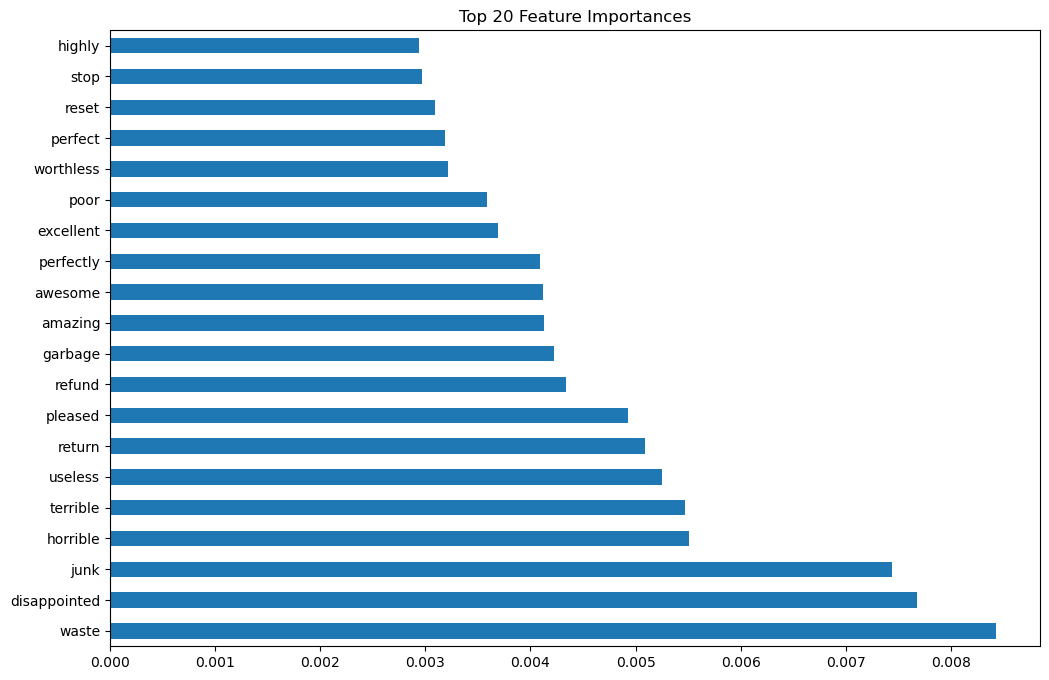

In [35]:

best_pipeline = bayes_search.best_estimator_
best_xgb_model = best_pipeline.named_steps['xgbregressor']

feature_importances = best_xgb_model.feature_importances_


vectorizer_step = best_pipeline.named_steps['countvectorizer']  # change to 'tfidfvectorizer' if used 
feature_names = vectorizer_step.get_feature_names_out()

importances = pd.Series(feature_importances, index=feature_names)

plt.figure(figsize=(12, 8))
importances.nlargest(20).plot(kind='barh')  
plt.title('Top 20 Feature Importances')
plt.show()

# XGBoost (TfidfVectorizer)

In [36]:
# also try tfidfvectorizer

# Simple BiLSTM 

In [7]:
X = df_review_normalised_subset['reviewText'].values
y = df_review_normalised_subset['overall'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

tokenizer = Tokenizer(num_words=2500)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = max([len(x) for x in sequences])
X_padded = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.25, random_state=42)

class ReviewsDataset(Dataset):
    def __init__(self, reviews, targets):
        self.reviews = reviews
        self.targets = targets
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = torch.tensor(self.reviews[idx], dtype=torch.long)
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return review, target

train_dataset = ReviewsDataset(X_train, y_train)
test_dataset = ReviewsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden)

# Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 64
hidden_dim = 64   # Reduced from 256
output_dim = 5  # Predicting ratings 1-5
n_layers = 2 # Reduced from 2
bidirectional = True
dropout = 0.5

model = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
model = model.to('cuda')  #  GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc='Training', leave=False)
    for texts, labels in progress_bar:
        texts, labels = texts.cuda(), labels.cuda()  # GPU
        optimizer.zero_grad()
        predictions = model(texts, torch.tensor([max_len]*texts.shape[0]).to('cuda'))
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return epoch_loss / len(iterator)


n_epochs = 5
for epoch in tqdm(range(n_epochs), desc='Epochs'):
    train_loss = train(model, train_loader, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}')



C:\Users\rzp98\AppData\Local\Temp\ipykernel_37340\2895166171.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(n_epochs), desc='Epochs'):


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\rzp98\AppData\Local\Temp\ipykernel_37340\2895166171.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(iterator, desc='Training', leave=False)


Training:   0%|          | 0/2536 [00:00<?, ?it/s]